In [ ]:
import random, numpy as np
import torch, torch.nn as nn, torch.optim as optim
import torchvision.transforms as xforms, torchvision.datasets, torchvision.utils
import matplotlib.pyplot as plt, matplotlib.animation as animation
import PIL
import pdb
import itertools
import pathlib
import IPython.display
from torchvision import datasets, models, transforms
from torchvision.models.resnet import BasicBlock
from tqdm.auto import tqdm
from PIL import Image

In [ ]:
# to transfer the images to and from my google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Make folders for the dataset. dataset/A is for images to turn into watercolor. dataset/B is for watercolor images

In [ ]:
!mkdir dataset
!mkdir dataset/A
!mkdir dataset/B

Unzip the images saved in the drive to this notebook

In [ ]:
!unzip "/content/drive/MyDrive/CPEN291_project/Data/other_imgs/other_imgs.zip" -d "/content/dataset/A/"
!unzip "/content/drive/MyDrive/CPEN291_project/Data/watercolor_imgs/watercolor_imgs.zip" -d "/content/dataset/B/"

In [ ]:
drive.flush_and_unmount()

Dataset (taken from https://github.com/eriklindernoren/PyTorch-GAN)

In [ ]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform_A, transform_B, unaligned=False):
        root_dir = pathlib.Path(root_dir).resolve()
        self.transformA = transform_A
        self.transformB = transform_B
        self.unaligned = unaligned
        self.files_A = sorted(root_dir.glob('A/*.jpg'))
        self.files_B = sorted(root_dir.glob('B/*.jpg'))

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = to_rgb(image_B)

        item_A = self.transformA(image_A)
        item_B = self.transformB(image_B)
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

Testing the dataset:

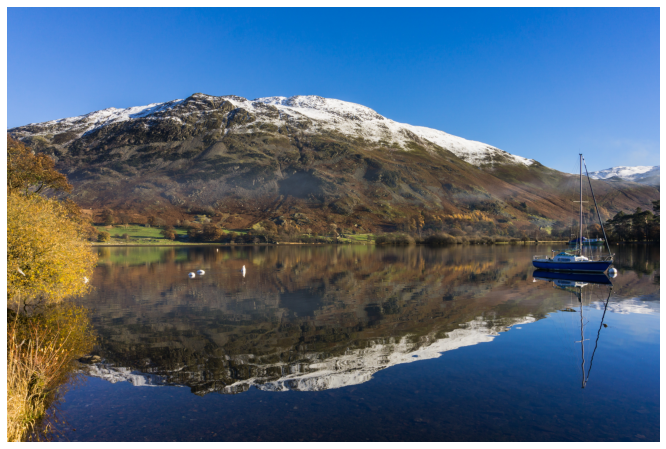

In [ ]:
xform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
dataset = ImageDataset("dataset", transform_A=xform, transform_B=xform)
dataset[0]
plt.figure(figsize=(16,8)); plt.axis('off')
plt.imshow(dataset[1]['B'].permute(1,2,0))
plt.imshow(dataset[2500]['A'].permute(1,2,0))

The critic: (taken from lecture)

In [ ]:
class Critic(nn.Module):
    def __init__(self, feat_dim=64):
        super(Critic, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, feat_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feat_dim, feat_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feat_dim * 2, feat_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feat_dim * 4, feat_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feat_dim * 8, 1, 4, 1, 0, bias=False),

            nn.AvgPool2d(4),
            nn.Sigmoid()
        )
        
        def init_layer(layer):
            if layer.__class__.__name__[:4] == 'Conv':
                nn.init.normal_(layer.weight, 0.0, 0.02)
            elif layer.__class__.__name__[:9] == 'BatchNorm':
                nn.init.normal_(layer.weight, 1.0, 0.02)
                nn.init.constant_(layer.bias, 0.0)

        self.layers.apply(init_layer)

        
    def forward(self, input):
        return self.layers(input)

The generator: (modified from lecture)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # got rid of vgg layers, changed kernal size to 4x4
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 4, 1, 1),
            nn.ReLU(inplace=True),
            nn.InstanceNorm2d(64, affine=True),
            nn.Conv2d(64, 128, 4, 1, 1),
            nn.ReLU(inplace=True),
            nn.InstanceNorm2d(128, affine=True),
            nn.Conv2d(128, 256, 4, 1, 1),
            nn.ReLU(inplace=True),
            nn.InstanceNorm2d(256, affine=True)
        )

        # 9 resnet blocks
        self.resnet_layers = nn.Sequential(
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            # BasicBlock(256, 256),
            # BasicBlock(256, 256),
            # BasicBlock(256, 256),
            # BasicBlock(256, 256),
        )

        # the 3 transposed convolution layers
        self.tconv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 1, 1),
            nn.InstanceNorm2d(128, affine=True),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 1, 1),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 3, 4, 1, 1),
            nn.ReLU(inplace=True),
            nn.Sigmoid()
        )

        def init_layer(layer):
            if type(layer).__name__[:4] == 'Conv':
                nn.init.xavier_uniform_(layer.weight)
            elif type(layer).__name__[:8] == 'Instance':
                nn.init.normal_(layer.weight, 1.0, 0.02)
                nn.init.constant_(layer.bias, 0.0)
            elif type(layer).__name__[:5] == "Basic":
                nn.init.xavier_uniform_(layer.conv1.weight)
                nn.init.xavier_uniform_(layer.conv2.weight)
                


        self.tconv_layers.apply(init_layer)
        self.resnet_layers.apply(init_layer)
        self.conv_layers.apply(init_layer)

        
    def forward(self, samples):
        # pass sample through all the layers
        # pdb.set_trace()
        out = self.conv_layers(samples)
        out = self.resnet_layers(out)
        out = self.tconv_layers(out)
        return out

In [ ]:
gen = Generator()
gen

Testing generator with input of an image. We can see some of the outlines of the original image

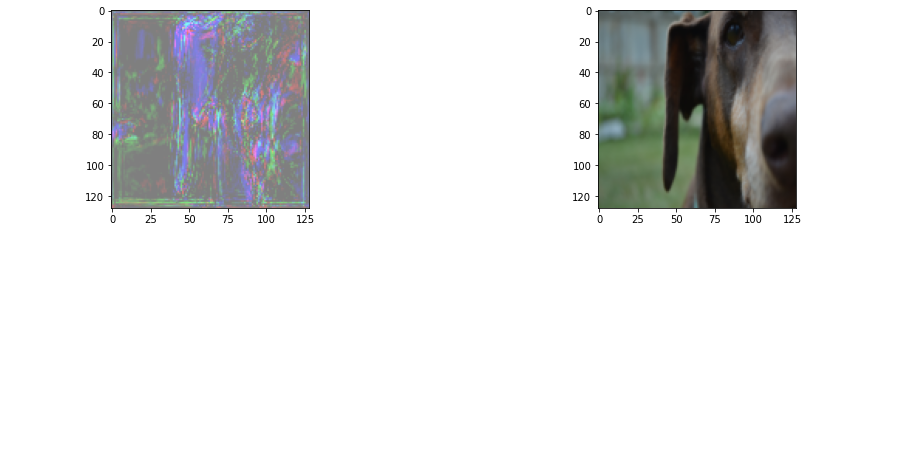

In [ ]:
device = torch.device('cuda:0')
gen = Generator().to(device)
gen.eval()
xform = torchvision.transforms.Compose([torchvision.transforms.Resize((128,128)), torchvision.transforms.ToTensor()])
dataset = ImageDataset("dataset", transform_A=xform, transform_B=xform)
fake_samples = gen(dataset[0]['A'].to(device).unsqueeze(0))
fig = plt.figure(figsize=(16,8)); plt.axis('off')
fig.add_subplot(2, 2, 1)
plt.imshow(fake_samples.detach().cpu().squeeze().permute(1,2,0))
fig.add_subplot(2, 2, 2)
plt.imshow(dataset[0]['A'].permute(1,2,0))
plt.show()

Training code: (taken from lecture and https://github.com/eriklindernoren/PyTorch-GAN)

In [ ]:
def run_train(model_genA, model_genB, model_critA, model_critB, ds, criterion_cycle, criterion_gen, opt_gen, opt_critA, opt_critB, scheduler_gen, scheduler_critA, scheduler_critB, dev, n_epochs=10, batch_sz=32, ref=None):
    model_genA = model_genA.to(dev)
    model_genB = model_genB.to(dev)
    model_critA = model_critA.to(dev)
    model_critB = model_critB.to(dev)
    model_genA.train()
    model_genB.train()
    model_critA.train()
    model_critB.train()
    ldr = torch.utils.data.DataLoader(ds, batch_size=batch_sz)
    discriminator_thresh = 2
    tq_epochs = tqdm(range(n_epochs), desc='epochs', unit='ep')
    loss_D = 0
    loss_G = 0
    for epoch_no, epoch in enumerate(tq_epochs):
        tq_iters = tqdm(ldr, desc='iter')
        for samples in tq_iters:
            real_A = samples['A'].to(dev)
            real_B = samples['B'].to(dev)

            # labels for real and fake images for the critics
            valid = torch.full((real_A.size()[0],), 1, dtype=torch.float, device=dev)
            fake = torch.full((real_A.size()[0],), 0, dtype=torch.float, device=dev)
            # handle the case where the sample is only 1 image
            if real_A.size()[0] == 1:
              valid = torch.tensor(1, dtype=torch.float, device=dev)
              fake = torch.tensor(0, dtype=torch.float, device=dev)
            # ------------------
            #  Train Generators
            # ------------------
            opt_gen.zero_grad()
            # Generator loss against the critics
            fake_B = model_genA(real_A)
            loss_GAN_AB = criterion_gen(model_critB(fake_B).squeeze(), valid) 
            fake_A = model_genB(real_B)
            loss_GAN_BA = criterion_gen(model_critA(fake_A).squeeze(), valid)
            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

            # Cycle loss between the starting and ending image
            recov_A = model_genB(fake_B)
            loss_cycle_A = criterion_cycle(recov_A, real_A)
            recov_B = model_genA(fake_A)
            loss_cycle_B = criterion_cycle(recov_B, real_B)

            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

            # Total loss
            loss_G = loss_GAN + 10 * loss_cycle

            # back-propogate
            loss_G.backward()
            opt_gen.step()

            # -----------------------
            #  Train Discriminator A
            # -----------------------

            opt_critA.zero_grad()

            # Real loss
            loss_real = criterion_gen(model_critA(real_A).squeeze(), valid)
            # Fake loss (on batch of previously generated samples)
            loss_fake = criterion_gen(model_critA(fake_A.detach()).squeeze(), fake)
            # Total loss
            loss_D_A = (loss_real + loss_fake) / 2

            if (loss_D_A.item() > discriminator_thresh):    # to make sure the critic does not get too strong
              loss_D_A.backward()
            opt_critA.step()

            # -----------------------
            #  Train Discriminator B
            # -----------------------

            opt_critB.zero_grad()

            # Real loss
            loss_real = criterion_gen(model_critB(real_B).squeeze(), valid)
            # Fake loss (on batch of previously generated samples)
            loss_fake = criterion_gen(model_critB(fake_B.detach()).squeeze(), fake)
            # Total loss
            loss_D_B = (loss_real + loss_fake) / 2

            if (loss_D_B.item() > discriminator_thresh):    # to make sure the critic does not get too strong
              loss_D_B.backward()
            opt_critB.step()

            loss_D = (loss_D_A + loss_D_B) / 2

            discriminator_thresh -= discriminator_thresh*1e-4

            tq_iters.set_postfix({'critics loss': loss_D.item(), 'generators loss': loss_G.item()})

        scheduler_gen.step()
        scheduler_critA.step()
        scheduler_critB.step()
        tq_epochs.write(f'critics loss {loss_D:.3f} / generators loss {loss_G:.3f}')
        # save the models after each epoch
        torch.save(model_genA.state_dict(), f"model_genA_epoch{epoch_no}")
        torch.save(model_genB.state_dict(), f"model_genB_epoch{epoch_no}")
        torch.save(model_critA.state_dict(), f"model_critA_epoch{epoch_no}")
        torch.save(model_critB.state_dict(), f"model_critB_epoch{epoch_no}")
        if ref is not None:
            ref_A, ref_imgs, regen_imgs = ref
            ref_fakes = model_genA(ref_A.unsqueeze(0)).detach().cpu()
            ref_imgs.append(torchvision.utils.make_grid(ref_fakes, normalize=True))
            regen = model_genB(ref_fakes.to(device))
            regen_imgs.append(torchvision.utils.make_grid(regen, normalize=True))

Testing generator with some watercolor images on only 1 image of a city

5026
5026
5026


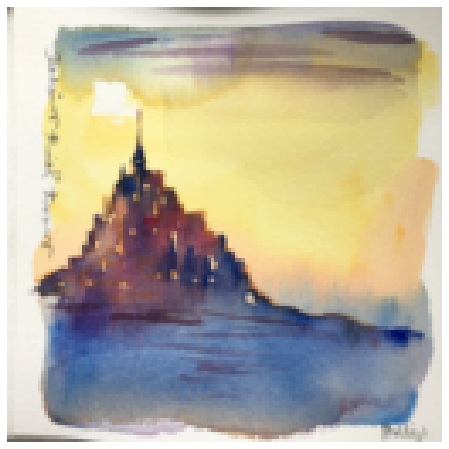

In [ ]:
xform_none = torchvision.transforms.Compose([torchvision.transforms.Resize((128,128)), torchvision.transforms.ToTensor()])
xform_flip = torchvision.transforms.Compose([torchvision.transforms.Resize((128,128)), torchvision.transforms.RandomHorizontalFlip(p=0.5), torchvision.transforms.ToTensor()])
dataset_none = ImageDataset('dataset', xform_none, xform_none)
dataset_flip = ImageDataset('dataset', xform_none, xform_flip)
# dataset = torch.utils.data.ConcatDataset([dataset_none, dataset_flip])
dataset = dataset_flip    # flipping 50% of image b since there are only half as many. They will get used twice and so the second time they are used they should be flipped
print(len(dataset_none))
print(len(dataset_flip))
print(len(dataset))
plt.figure(figsize=(16,8)); plt.axis('off')
plt.imshow(torchvision.utils.make_grid(dataset[100]['B'], normalize=True).permute(1,2,0))

In [ ]:
device = torch.device('cuda:0')
#device = torch.device('cpu')


ref_fake_imgs = []
ref_A = dataset[0]['A'].to(device)
regen_imgs = []


model_genA = Generator()
model_genB = Generator()
model_critA = Critic(feat_dim=64)
model_critB = Critic(feat_dim=64)

# model_genA.load_state_dict(torch.load("model_genA"))
# model_genB.load_state_dict(torch.load("model_genB"))
# model_critA.load_state_dict(torch.load("model_critA"))
# model_critB.load_state_dict(torch.load("model_critB"))
criterion_cycle = nn.L1Loss()   # loss between the starting image and the same image passed through the two generators
criterion_gen = nn.BCELoss()    # loss for the generators when evaluated with the critic

opt_gen = torch.optim.Adam(
    itertools.chain(model_genA.parameters(), model_genB.parameters()), lr=1e-4
)
opt_critA = torch.optim.Adam(model_critA.parameters(), lr=1e-4)
opt_critB = torch.optim.Adam(model_critB.parameters(), lr=1e-4)

lr_scheduler_gen = torch.optim.lr_scheduler.StepLR(opt_gen, step_size=3, gamma=0.1)
lr_scheduler_critA = torch.optim.lr_scheduler.StepLR(opt_critA, step_size=3, gamma=0.1)
lr_scheduler_critB = torch.optim.lr_scheduler.StepLR(opt_critB, step_size=3, gamma=0.1)

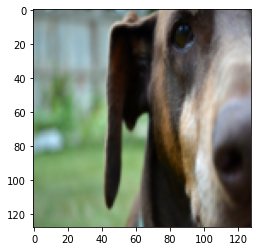

In [ ]:
plt.imshow(torchvision.utils.make_grid(dataset[0]['A'], normalize=True).permute(1,2,0))

In [ ]:
run_train(model_genA, model_genB, model_critA, model_critB, dataset, criterion_cycle, criterion_gen, opt_gen, opt_critA, opt_critB, lr_scheduler_gen, lr_scheduler_critA, lr_scheduler_critB, device, n_epochs=5, batch_sz=5, ref=(ref_A,ref_fake_imgs,regen_imgs))


critics loss 1.068 / generators loss 4.449



critics loss 1.034 / generators loss 2.882



critics loss 0.542 / generators loss 3.812



critics loss 0.724 / generators loss 3.281



critics loss 0.808 / generators loss 2.908



Generated images from the model

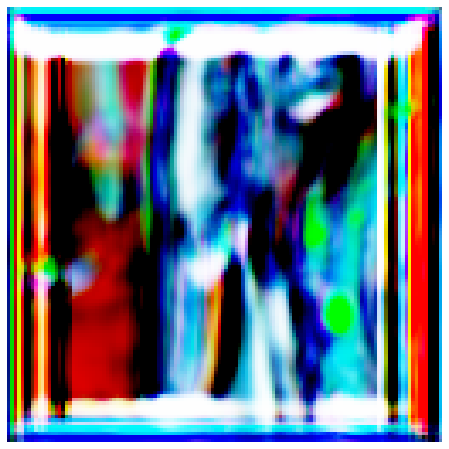

In [ ]:
fig = plt.figure(figsize=(16,8)); plt.axis('off')
frames = [[plt.imshow(img.permute(1,2,0), animated=True)] for img in ref_fake_imgs]
anim = animation.ArtistAnimation(fig, frames, interval=1000, repeat_delay=1000, blit=True)
IPython.display.HTML(anim.to_jshtml())

Regenerated images from the model

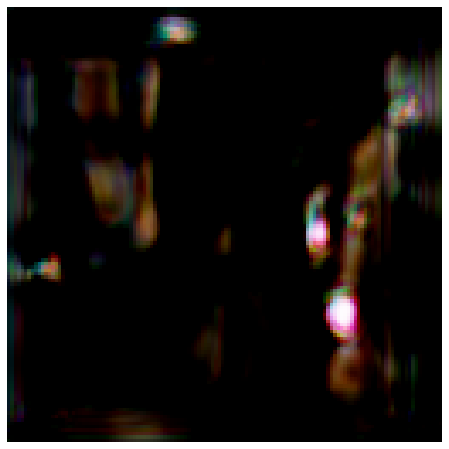

In [ ]:
fig = plt.figure(figsize=(16,8)); plt.axis('off')
frames = [[plt.imshow(img.detach().cpu().permute(1,2,0), animated=True)] for img in regen_imgs]
anim = animation.ArtistAnimation(fig, frames, interval=1000, repeat_delay=1000, blit=True)
IPython.display.HTML(anim.to_jshtml())

Saving the models to continue training later

In [ ]:
import pickle
torch.save(model_genA.state_dict(), "model_genA")
torch.save(model_genB.state_dict(), "model_genB")
torch.save(model_critA.state_dict(), "model_critA")
torch.save(model_critB.state_dict(), "model_critB")

def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

save_object(opt_gen, "opt_gen.pkl")
save_object(opt_critA, "opt_critA.pkl")
save_object(opt_critB, "opt_critB.pkl")
save_object(lr_scheduler_gen, "lr_scheduler_gen.pkl")
save_object(lr_scheduler_critA, "lr_scheduler_critA")
save_object(lr_scheduler_critB, "lr_scheduler_critB.pkl")